In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import yfinance as yf

plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
proxy='http://127.0.0.1:7890'
os.environ['HTTP_PROXY']=proxy
os.environ['HTTPS_PROXY']=proxy

In [3]:
def fetch_stock_data(symbol, start_date=None, end_date=None, period='3y',save_local=True, data_dir='data'):
    try:
        if save_local and not os.path.exists(data_dir):
            os.makedirs(data_dir)

        filename = f"{symbol}_{period}"

        if start_date and end_date:
            filename = f"{symbol}_{start_date}_{end_date}"

        filename = f"{filename}.csv"
        filepath = os.path.join(data_dir, filename)

        if os.path.exists(filepath):
            data = load_local_stock_data(symbol, period)
            print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
            print(f"Total records: {len(data)}")
            return data
        else:
            print(f"Fetching data for {symbol} from yfinance...")
            if start_date and end_date:
                data = yf.download(symbol, start=start_date, end=end_date)
            else:
                data = yf.download(symbol, period=period)

        data = data.sort_index()

        data = data.rename(columns={
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume'
        })

        data = data[['open', 'high', 'low', 'close', 'volume']]

        if save_local:
            data.to_csv(filepath)
            print(f"Successfully saved data to local file: {filepath}")

        print(f"Successfully fetched data for {symbol}")
        print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
        print(f"Total records: {len(data)}")

        return data

    except Exception as e:
        print(f"Error fetching data: {str(e)}")
        raise

def load_local_stock_data(symbol, period):
    file_path = 'data/'+symbol+'_'+period+'.csv'
    try:
        print(f"Loading data from local file: {file_path}")
        df = pd.read_csv(file_path, header=None)
        rows = df.iloc[3:].values
        stock_data=pd.DataFrame(rows, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
        stock_data['date'] = pd.to_datetime(stock_data['date'])
        stock_data['open'] = pd.to_numeric(stock_data['open'])
        stock_data['high'] = pd.to_numeric(stock_data['high'])
        stock_data['low'] = pd.to_numeric(stock_data['low'])
        stock_data['close'] = pd.to_numeric(stock_data['close'])
        stock_data['volume'] = pd.to_numeric(stock_data['volume'])

        stock_data = stock_data.set_index('date')
        print(f"Successfully loaded data for {symbol}")
        return stock_data

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

def calculate_moving_averages(df, short_window=5, long_window=20):
    data = df.copy()

    data['ma_short'] = data['close'].rolling(window=int(short_window), min_periods=1).mean()
    data['ma_long'] = data['close'].rolling(window=int(long_window), min_periods=1).mean()

    return data

def generate_signals(df):
    data = df.copy(deep=True)

    data['signal'] = 0

    for i in range(1, len(data)):
        current_idx = data.index[i]
        prev_idx = data.index[i-1]

        if data.loc[current_idx, 'ma_short'] > data.loc[current_idx, 'ma_long'] and \
           data.loc[prev_idx, 'ma_short'] <= data.loc[prev_idx, 'ma_long']:
            data.loc[current_idx, 'signal'] = 1

        elif data.loc[current_idx, 'ma_short'] < data.loc[current_idx, 'ma_long'] and \
             data.loc[prev_idx, 'ma_short'] >= data.loc[prev_idx, 'ma_long']:
            data.loc[current_idx, 'signal'] = -1

    return data


In [4]:
def backtest(df, initial_capital=10000, transaction_cost=0.001):
    data = df.copy()

    data['cash'] = initial_capital
    data['shares'] = 0
    data['total'] = initial_capital
    data['returns'] = 0.0
    data['strategy_cum_returns'] = 1.0
    data['benchmark_cum_returns'] = 1.0

    trades = []
    current_cash = initial_capital
    current_shares = 0
    prev_price = data['close'].iloc[0]

    benchmark_cum_ret = 1.0

    for i in range(len(data)):
        date = data.index[i]
        price = data['close'].iloc[i]
        signal = data['signal'].iloc[i]

        daily_return = (price / prev_price) - 1
        benchmark_cum_ret *= (1 + daily_return)
        data.at[date, 'benchmark_cum_returns'] = benchmark_cum_ret
        prev_price = price

        if signal == 1 and current_shares == 0:
            max_shares = current_cash / (price * (1 + transaction_cost))
            shares_to_buy = int(max_shares)  # Buy whole shares

            if shares_to_buy > 0:
                cost = shares_to_buy * price * (1 + transaction_cost)
                current_cash -= cost
                current_shares += shares_to_buy

                trades.append({
                    'date': date,
                    'type': 'BUY',
                    'price': price,
                    'shares': shares_to_buy,
                    'cost': cost,
                    'cash_after': current_cash,
                    'shares_after': current_shares
                })

        elif signal == -1 and current_shares > 0:
            revenue = current_shares * price * (1 - transaction_cost)
            current_cash += revenue
            shares_sold = current_shares
            current_shares = 0

            trades.append({
                'date': date,
                'type': 'SELL',
                'price': price,
                'shares': shares_sold,
                'revenue': revenue,
                'cash_after': current_cash,
                'shares_after': current_shares
            })

        portfolio_value = current_cash + current_shares * price
        data.at[date, 'cash'] = current_cash
        data.at[date, 'shares'] = current_shares
        data.at[date, 'total'] = portfolio_value

        if i > 0:
            prev_portfolio = data['total'].iloc[i-1]
            data.at[date, 'returns'] = (portfolio_value / prev_portfolio) - 1
            data.at[date, 'strategy_cum_returns'] = data['strategy_cum_returns'].iloc[i-1] * (1 + data['returns'].iloc[i])

    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        trades_df.set_index('date', inplace=True)

    return data, trades_df

def calculate_performance_metrics(backtest_results, trades_df):
    start_date = backtest_results.index[0]
    end_date = backtest_results.index[-1]
    days_traded = (end_date - start_date).days
    years_traded = days_traded / 365.25

    initial_value = backtest_results['total'].iloc[0]
    final_value = backtest_results['total'].iloc[-1]
    total_return = (final_value - initial_value) / initial_value * 100

    annualized_return = ((1 + total_return / 100) ** (1 / years_traded) - 1) * 100 if years_traded > 0 else 0

    benchmark_return = (backtest_results['benchmark_cum_returns'].iloc[-1] - 1) * 100
    benchmark_annualized = ((1 + benchmark_return / 100) ** (1 / years_traded) - 1) * 100 if years_traded > 0 else 0

    daily_returns = backtest_results['returns'].dropna()
    sharpe_ratio = np.sqrt(252) * (daily_returns.mean() / daily_returns.std()) if daily_returns.std() != 0 else 0

    rolling_max = backtest_results['total'].cummax()
    daily_drawdown = backtest_results['total'] / rolling_max - 1.0
    max_drawdown = daily_drawdown.min() * 100

    num_trades = len(trades_df)
    win_rate = 0
    avg_trade_return = 0

    if num_trades >= 2:
        winning_trades = 0
        total_trade_returns = 0

        for i in range(0, len(trades_df), 2):
            if i + 1 >= len(trades_df):
                break

            buy = trades_df.iloc[i]
            sell = trades_df.iloc[i+1]

            if sell['revenue'] > buy['cost']:
                winning_trades += 1

            trade_return = (sell['revenue'] - buy['cost']) / buy['cost'] * 100
            total_trade_returns += trade_return

        win_rate = (winning_trades / (num_trades / 2)) * 100 if num_trades > 0 else 0
        avg_trade_return = total_trade_returns / (num_trades / 2) if num_trades > 0 else 0

    return {
        'start_date': start_date.date(),
        'end_date': end_date.date(),
        'years_traded': round(years_traded, 2),
        'total_return': round(total_return, 2),
        'annualized_return': round(annualized_return, 2),
        'benchmark_return': round(benchmark_return, 2),
        'benchmark_annualized': round(benchmark_annualized, 2),
        'sharpe_ratio': round(sharpe_ratio, 2),
        'max_drawdown': round(max_drawdown, 2),
        'num_trades': num_trades,
        'win_rate': round(win_rate, 2),
        'avg_trade_return': round(avg_trade_return, 2)
    }


In [5]:
def plot_strategy(df, symbol, short_window, long_window, last_n_days=None,save_path=None):
    if last_n_days:
        cutoff_date = df.index.max() - timedelta(days=last_n_days)
        data = df[df.index >= cutoff_date]
        title_suffix = f" (Last {last_n_days} Days)"
    else:
        data = df
        title_suffix = ""

    fig, ax = plt.subplots(figsize=(16, 10))

    ax.plot(data.index, data['close'], label='Close Price', linewidth=2, color='blue', alpha=0.7)
    ax.plot(data.index, data['ma_short'], label=f'{short_window}-Day MA', linewidth=2, color='orange')
    ax.plot(data.index, data['ma_long'], label=f'{long_window}-Day MA', linewidth=2, color='green')

    buy_signals = data[data['signal'] == 1]
    sell_signals = data[data['signal'] == -1]

    ax.scatter(buy_signals.index, buy_signals['close'],
              label='BUY Signal', marker='^', color='g', s=100, zorder=5)
    ax.scatter(sell_signals.index, sell_signals['close'],
              label='SELL Signal', marker='v', color='r', s=100, zorder=5)

    for i, (date, row) in enumerate(buy_signals.iterrows()):
        date_str = date.strftime('%Y-%m-%d')
        price_str = f"${row['close']:.2f}"

        ax.annotate(f"BUY:{price_str}\n{date_str}",
                    xy=(date, row['close']),
                    xytext=(0,15),
                    textcoords='offset points',
                    fontsize=8,
                    color='green',
                    bbox=dict(boxstyle='round,pad=0.3', fc="white", ec="green", alpha=0.7)
        )

    for i, (date, row) in enumerate(sell_signals.iterrows()):
        date_str = date.strftime('%Y-%m-%d')
        price_str = f"${row['close']:.2f}"

        ax.annotate(
            f"SELL: {price_str}\n{date_str}",
            xy=(date, row['close']),
            xytext=(0, -30),
            textcoords='offset points',
            fontsize=8,
            color='red',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.7)
        )
    ax.set_title(f'{symbol} Price with {short_window}-Day and {long_window}-Day Moving Averages{title_suffix}',
                fontsize=16, pad=20)
    ax.set_xlabel('Date', fontsize=14, labelpad=10)
    ax.set_ylabel('Price', fontsize=14, labelpad=10)
    ax.legend(fontsize=12)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Strategy plot saved to: {save_path}")
    else:
        plt.show()

def plot_performance(backtest_results, symbol, save_path=None):

    fig, ax = plt.subplots(figsize=(16, 10))

    ax.plot(backtest_results.index, backtest_results['strategy_cum_returns'],
            label='Strategy Returns', linewidth=2, color='blue')
    ax.plot(backtest_results.index, backtest_results['benchmark_cum_returns'],
            label='Buy & Hold Returns', linewidth=2, color='gray', linestyle='--')

    ax.set_title(f'{symbol} Strategy Performance vs Benchmark',
                fontsize=16, pad=20)
    ax.set_xlabel('Date', fontsize=14, labelpad=10)
    ax.set_ylabel('Cumulative Returns', fontsize=14, labelpad=10)
    ax.legend(fontsize=12)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Performance plot saved to: {save_path}")
    else:
        plt.show()


def print_performance_metrics(metrics):
    print("\n=== Strategy Performance Metrics ===")
    print(f"Date Range: {metrics['start_date']} to {metrics['end_date']}")
    print(f"Trading Period: {metrics['years_traded']} years")
    print("\n=== Returns ===")
    print(f"Total Strategy Return: {metrics['total_return']}%")
    print(f"Annualized Strategy Return: {metrics['annualized_return']}%")
    print(f"Total Benchmark Return (Buy & Hold): {metrics['benchmark_return']}%")
    print(f"Annualized Benchmark Return: {metrics['benchmark_annualized']}%")
    print("\n=== Risk Metrics ===")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']}")
    print(f"Maximum Drawdown: {metrics['max_drawdown']}%")
    print("\n=== Trading Statistics ===")
    print(f"Total Trades: {metrics['num_trades']}")
    print(f"Win Rate: {metrics['win_rate']}%")
    print(f"Average Trade Return: {metrics['avg_trade_return']}%")


In [6]:
def save_backtest_results(backtest_results, trades_df, metrics, symbol,
                          short_window, long_window, save_dir='results'):
    param_dir = f"{symbol}_short{short_window}_long{long_window}"
    full_save_dir = os.path.join(save_dir, param_dir)
    if not os.path.exists(full_save_dir):
        os.makedirs(full_save_dir, exist_ok=True)

    backtest_path = os.path.join(full_save_dir, f"{param_dir}_daily_results.csv")
    backtest_results.to_csv(backtest_path, encoding='utf-8')
    print(f" Backtest results saved at: {backtest_path}")

    if not trades_df.empty:
        trades_path = os.path.join(full_save_dir, f"{param_dir}_trades.csv")
        trades_df.to_csv(trades_path, encoding='utf-8')
        print(f" Trading records saved at: {trades_path}")

    metrics_df = pd.DataFrame([metrics])
    if 'symbol' not in metrics_df.columns:
        metrics_df.insert(0, 'symbol', symbol)
    if 'short_window' not in metrics_df.columns:
        metrics_df.insert(1, 'short_window', short_window)
    if 'long_window' not in metrics_df.columns:
        metrics_df.insert(2, 'long_window', long_window)
    metrics_path = os.path.join(full_save_dir, f"{param_dir}_metrics.csv")
    metrics_df.to_csv(metrics_path, index=False, encoding='utf-8')
    print(f" Metrics saved at: {metrics_path}")

def analyze_multiple_parameters(stock_data, symbol,
                                short_windows=[5, 10, 15],
                                long_windows=[30, 50, 60],
                                initial_capital=10000,
                                transaction_cost=0.001,
                                last_n_days=360,
                                save_individual=True,
                                save_comparison=True):

    print(f"\n=== Starting multiple parameters analysis（Stock：{symbol}）===")
    print(f"Parameters input：Short window{short_windows}，Long window{long_windows}")

    all_metrics = []

    for short_win in short_windows:
        for long_win in long_windows:
            if short_win >= long_win:
                print(f" Skip invalid windows（short window{short_win} ≥ long window{long_win}）")
                continue

            print(f"\n--- Backtesting ：Short{short_win}days | Long{long_win}days ---")

            stock_data_with_ma = calculate_moving_averages(stock_data, short_win, long_win)
            stock_data_with_signals = generate_signals(stock_data_with_ma)
            backtest_res, trades_df = backtest(stock_data_with_signals, initial_capital, transaction_cost)
            metrics = calculate_performance_metrics(backtest_res, trades_df)

            metrics['symbol'] = symbol
            metrics['short_window'] = short_win
            metrics['long_window'] = long_win
            all_metrics.append(metrics)

            print(f"Core metrics：Annualized return {metrics['annualized_return']}% | Max draw down{metrics['max_drawdown']}% | Sharpe ratio {metrics['sharpe_ratio']}")

            if save_individual:
                save_backtest_results(backtest_res, trades_df, metrics, symbol, short_win, long_win)

    metrics_comparison = pd.DataFrame(all_metrics)
    key_cols = ['symbol', 'short_window', 'long_window', 'annualized_return',
                'max_drawdown', 'sharpe_ratio', 'win_rate', 'num_trades']
    metrics_comparison = metrics_comparison[key_cols + [col for col in metrics_comparison.columns if col not in key_cols]]

    if save_comparison:
        comparison_dir = 'results/parameter_comparison'
        os.makedirs(comparison_dir, exist_ok=True)
        comparison_path = os.path.join(comparison_dir, f"{symbol}_parameter_comparison.csv")
        metrics_comparison.to_csv(comparison_path, index=False, encoding='utf-8')
        print(f"\n All parameter comparisons saved at: {comparison_path}")

    plot_parameter_comparison(metrics_comparison, symbol)

    print(f"\n=== Multiple parameters backtesting analysis finished ===")
    return metrics_comparison

def plot_parameter_comparison(metrics_comparison, symbol):

    fig, ax = plt.subplots(figsize=(12, 8))

    scatter = ax.scatter(
        x=-metrics_comparison['max_drawdown'],
        y=metrics_comparison['annualized_return'],
        s=metrics_comparison['sharpe_ratio'] * 50,
        c=metrics_comparison['win_rate'],
        cmap='Greens',
        alpha=0.7,
        edgecolors='black'
    )

    for idx, row in metrics_comparison.iterrows():
        ax.annotate(
            f"{row['short_window']}-{row['long_window']}",
            xy=(-row['max_drawdown'], row['annualized_return']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9
        )

    ax.set_xlabel('Max Drawdown (Absolute Value, %)', fontsize=12)
    ax.set_ylabel('Annualized Return(%)', fontsize=12)
    ax.set_title(f'{symbol} Comparision of MA Parameter Combinations(Bubble Size=Sharpe Ratio, Color=Win Rate)', fontsize=14, pad=20)
    ax.grid(True, linestyle='--', alpha=0.5)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Win Rate(%)', fontsize=10)

    plt.tight_layout()
    plot_dir = 'results/parameter_comparison'
    os.makedirs(plot_dir, exist_ok=True)
    plot_path = os.path.join(plot_dir, f"{symbol}_parameter_comparison_plot.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Parameter comparison plot saved at: {plot_path}")

In [7]:
SYMBOL = ("DIA")
LAST_N_DAYS = 1000
INITIAL_CAPITAL = 10000.0
TRANSACTION_COST=0.001
TEST_SHORT_WINDOWS = [5, 10, 15, 20,25, 30]
TEST_LONG_WINDOWS = [30, 40, 50, 60,80,100,120,]

print(f"Fetching data for {SYMBOL}...")
stock_data = fetch_stock_data(SYMBOL, period='3y')

Fetching data for DIA...
Loading data from local file: data/DIA_3y.csv
Successfully loaded data for DIA
Date range: 2022-09-26 to 2025-09-24
Total records: 752



=== Starting multiple parameters analysis（Stock：DIA）===
Parameters input：Short window[5, 10, 15, 20, 30]，Long window[30, 40, 50, 60, 80, 100, 120]

--- Backtesting ：Short5days | Long30days ---
Core metrics：Annualized return 8.95% | Max draw down-8.17% | Sharpe ratio 0.96
 Backtest results saved at: results/DIA_short5_long30/DIA_short5_long30_daily_results.csv
 Trading records saved at: results/DIA_short5_long30/DIA_short5_long30_trades.csv
 Metrics saved at: results/DIA_short5_long30/DIA_short5_long30_metrics.csv

--- Backtesting ：Short5days | Long40days ---
Core metrics：Annualized return 7.95% | Max draw down-10.78% | Sharpe ratio 0.84
 Backtest results saved at: results/DIA_short5_long40/DIA_short5_long40_daily_results.csv
 Trading records saved at: results/DIA_short5_long40/DIA_short5_long40_trades.csv
 Metrics saved at: results/DIA_short5_long40/DIA_short5_long40_metrics.csv

--- Backtesting ：Short5days | Long50days ---
Core metrics：Annualized return 9.66% | Max draw down-8.44% | 

,short_window,long_window,annualized_return,max_drawdown,sharpe_ratio
10,10,60,14.59,-9.28,1.34
12,10,100,14.39,-7.24,1.30
13,10,120,12.70,-9.32,1.15



--- Show best parameters of (Short10.0 Days | Long 60.0 Days）plot ---
Strategy plot saved to: results/plots/DIA/DIA_strategy_short10.0_long60.0_1000days.png
Performance plot saved to: results/plots/DIA/DIA_performance_short10.0_long60.0_1000days.png


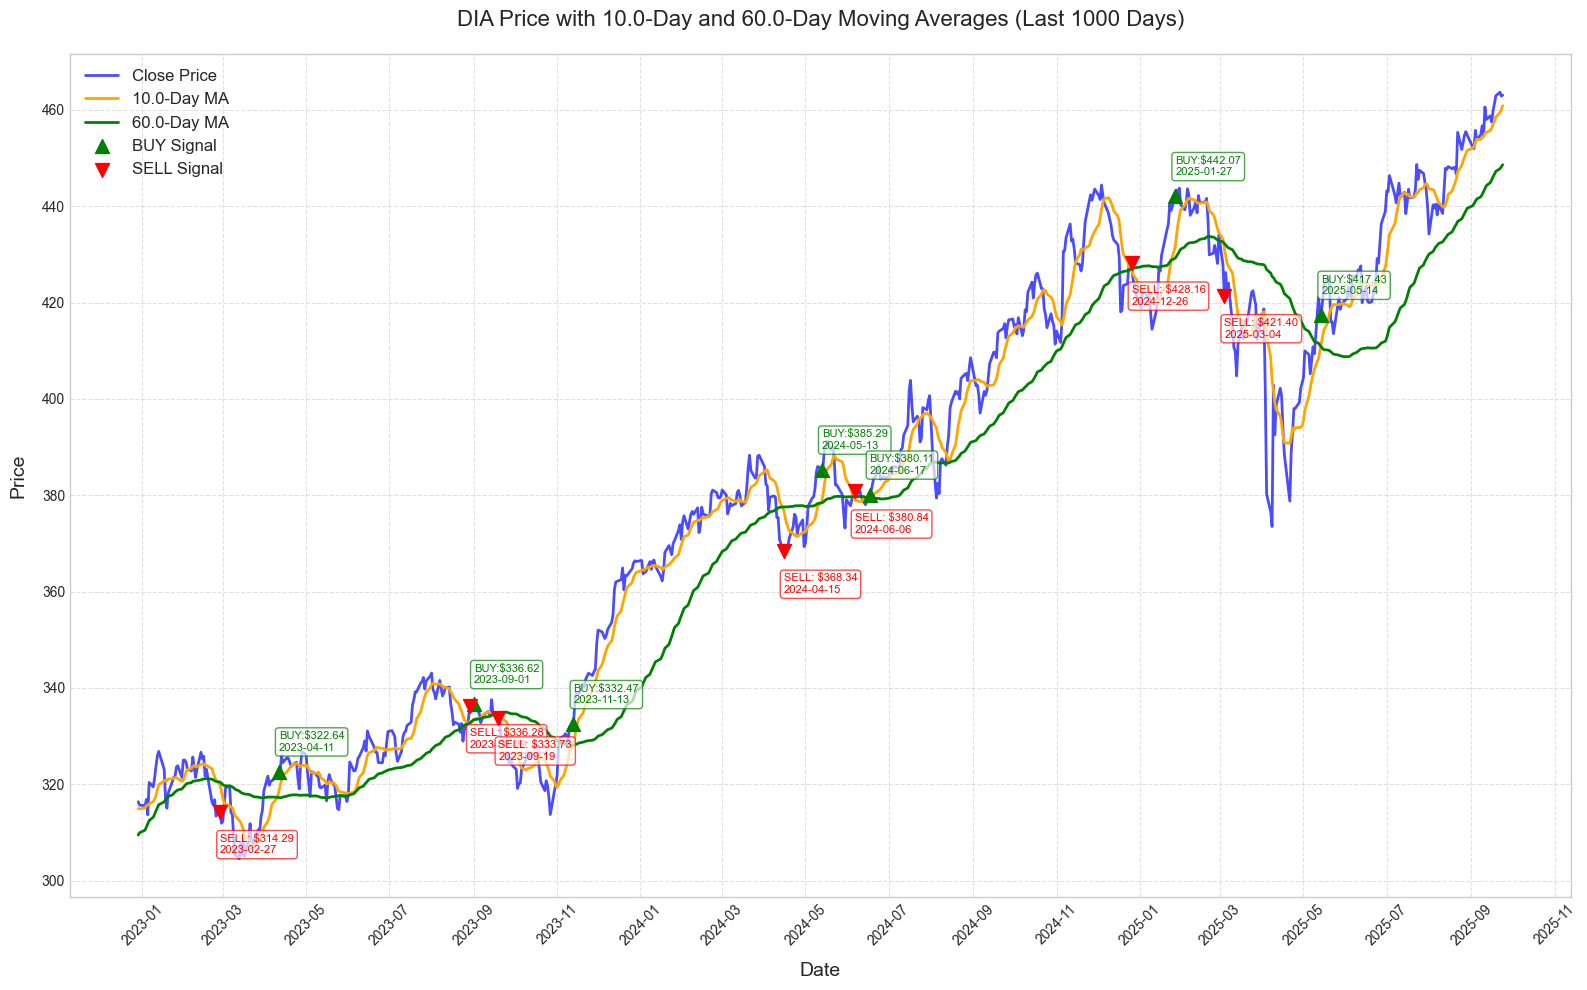

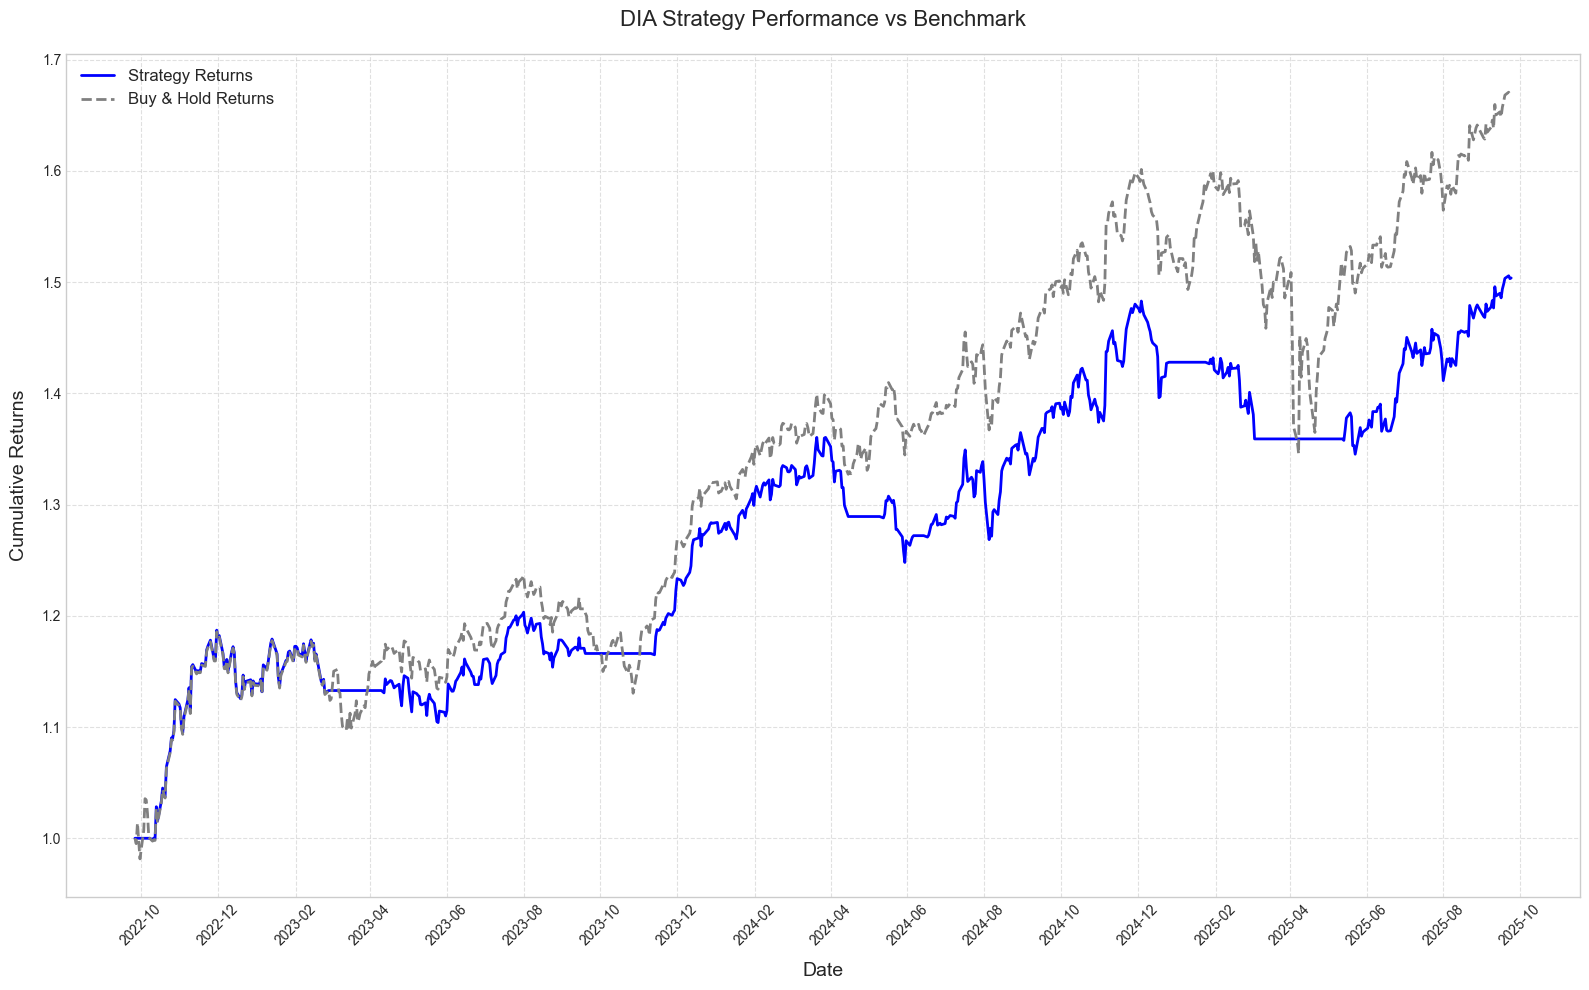

In [8]:
param_comparison = analyze_multiple_parameters(
        stock_data=stock_data,
        symbol=SYMBOL,
        short_windows=TEST_SHORT_WINDOWS,
        long_windows=TEST_LONG_WINDOWS,
        initial_capital=INITIAL_CAPITAL,
        transaction_cost=TRANSACTION_COST,
        last_n_days=LAST_N_DAYS,
        save_individual=True,
        save_comparison=True
    )
print("\n=== Best parameters combinations（Sort by annualized reuturn Top3）===")
top3_params = param_comparison.nlargest(3, 'annualized_return')[['short_window', 'long_window', 'annualized_return', 'max_drawdown', 'sharpe_ratio']]
display(top3_params)


best_short = top3_params.iloc[0]['short_window']
best_long = top3_params.iloc[0]['long_window']
print(f"\n--- Show best parameters of (Short{best_short} Days | Long {best_long} Days）plot ---")

stock_data_with_ma_best = calculate_moving_averages(stock_data, best_short, best_long)
stock_data_with_signals_best = generate_signals(stock_data_with_ma_best)
backtest_res_best, _ = backtest(stock_data_with_signals_best, INITIAL_CAPITAL, TRANSACTION_COST)

save_root = os.path.join('results', 'plots', SYMBOL)
param_suffix = f"short{best_short}_long{best_long}"

strategy_save_path = os.path.join(
    save_root,
    f"{SYMBOL}_strategy_{param_suffix}_{LAST_N_DAYS}days.png"
)

performance_save_path = os.path.join(
    save_root,
    f"{SYMBOL}_performance_{param_suffix}_{LAST_N_DAYS}days.png"
)

plot_strategy(stock_data_with_signals_best, SYMBOL, best_short, best_long, LAST_N_DAYS, strategy_save_path)
plot_performance(backtest_res_best, SYMBOL,performance_save_path)